In [1]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans

In [2]:
df = pd.read_excel("Updated file AQI.xlsx")

In [3]:
df.head()

,measure,State,sex,age,cause,year,Deaths,AQI,Number of Hospitals2,Number of Beds2,NO2,SO2,PM10,PM2.5
0,Deaths,Uttar Pradesh,Male,15-19 years,Asthma,2015,72.466215,179.594079,831,54965,28.566038,10.679245,181.716981,96.8
1,Deaths,Uttar Pradesh,Female,15-19 years,Asthma,2015,110.270358,179.594079,831,54965,28.566038,10.679245,181.716981,96.8
2,Deaths,Uttar Pradesh,Male,20-24 years,Asthma,2015,112.532770,179.594079,831,54965,28.566038,10.679245,181.716981,96.8
3,Deaths,Uttar Pradesh,Female,20-24 years,Asthma,2015,133.389949,179.594079,831,54965,28.566038,10.679245,181.716981,96.8
4,Deaths,Uttar Pradesh,Male,30-34 years,Asthma,2015,235.578511,179.594079,831,54965,28.566038,10.679245,181.716981,96.8


In [4]:
# Handling missing values with median imputation
pollution_columns = ["NO2", "SO2", "PM10"]
df[pollution_columns] = df[pollution_columns].fillna(df[pollution_columns].median())

In [5]:
features = ["AQI", "NO2", "SO2", "PM10", "PM2.5"]

In [6]:
# Standardizing the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[features])

In [7]:
# PCA for HSI calculation
pca = PCA(n_components=1)
pca_index = pca.fit_transform(scaled_features)
df["HSI_PCA"] = (pca_index - pca_index.min()) / (pca_index.max() - pca_index.min())

In [8]:
# Regression Analysis for HSI
X = df[features]
y = df["Deaths"]

In [9]:
regression_model = LinearRegression()
regression_model.fit(X, y)
regression_index = regression_model.predict(X)
df["HSI_Regression"] = (regression_index - regression_index.min()) / (regression_index.max() - regression_index.min())

In [10]:
# Final HSI Calculation (average of PCA & Regression)
df["HSI_Final"] = (df["HSI_PCA"] + df["HSI_Regression"]) / 2

In [11]:
# Aggregating HSI at state level
state_hsi = df.groupby("State")["HSI_Final"].mean().reset_index()

In [12]:
# Clustering states into risk categories
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
state_hsi["Cluster"] = kmeans.fit_predict(state_hsi[["HSI_Final"]])

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [13]:
# Mapping clusters to risk levels
risk_labels = {0: "Low Risk", 1: "Moderate Risk", 2: "High Risk"}
state_hsi["Risk Category"] = state_hsi["Cluster"].map(risk_labels)

In [18]:
new_df=state_hsi['Risk Category'].value_counts()

In [17]:
import seaborn as sns


In [19]:
new_df.reset_index()

,Risk Category,count
0,Moderate Risk,11
1,Low Risk,9
2,High Risk,3


In [21]:
new_df.columns=['Risk_Category','count']

In [22]:
new_df.columns

['Risk_Category', 'count']

In [29]:
temp=new_df.reset_index()

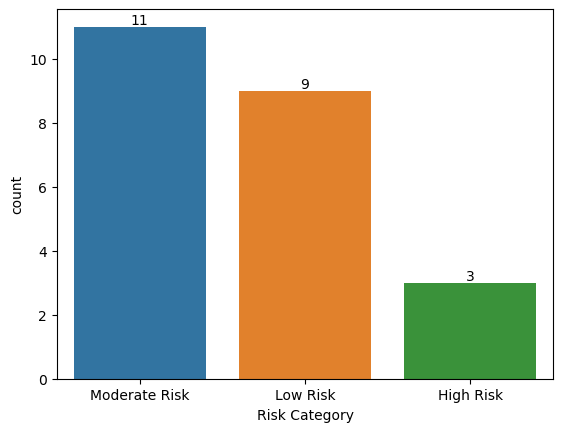

In [30]:
ax=sns.barplot(x='Risk Category', y='count', data=temp)

for bars in ax.containers:
    ax.bar_label(bars)

In [31]:
# Merge cluster labels back into the main dataset
df = df.merge(state_hsi[["State", "Cluster"]], on="State", how="left")

In [32]:
# Save the output
df.to_csv("HSI_Results.csv", index=False)
state_hsi.to_csv("State_HSI_Clusters.csv", index=False)

print("HSI calculation and clustering completed. Results saved as CSV files.")

HSI calculation and clustering completed. Results saved as CSV files.
